In [488]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

In [483]:
def get_raw_df():
    return pd.read_csv(r"C:\Users\91910\Desktop\IIT_Kanpur\Semester6\MSE643A\Project\bandGap\dielectric_constant_data.csv")

def get_propsFromStruct(df): #returns len, angles and periodic properties of a crystal structure for all compounds
    structure_arr = []

    for struct in df['structure']:
        finalStruct_arr = []
        modLen_arr = []
        modAngl_arr = []
        #modPerio_arr = []
        split_arr = struct.split('\n')
        len_arr = split_arr[2].split()[2:]
        angl_arr = split_arr[3].split()[1:]
        #perio_arr = split_arr[4].split()[2:]
        for i in range(3):
            modLen_arr.append(float(len_arr[i]))
            modAngl_arr.append(float(angl_arr[i]))
        for ele in modLen_arr:
            finalStruct_arr.append(ele)
        for ele in modAngl_arr:
            finalStruct_arr.append(ele)
#         for ele in perio_arr:
#             finalStruct_arr.append(ele)
        structure_arr.append(finalStruct_arr)
        
    return np.array(structure_arr)

def transform_raw_e_electronic(df): #transforms e_electronic into model readable values
    res = []
    for tensor_per_struct in df['e_electronic']:
        tensor_split = tensor_per_struct[2:-2].split(',')
        for i in range(len(tensor_split)):
            if (i==2 or i==5):
                tensor_split[i] = tensor_split[i].strip()[:-1]
            elif (i==3 or i==6):
                tensor_split[i] = tensor_split[i].strip()[1:]
        for j in range(len(tensor_split)):
            tensor_split[j] = float(tensor_split[j])
        res.append(tensor_split)
    return np.array(res)

def transform_raw_e_total(df): #transforms e_total into model readable values
    res = []
    for tensor_per_struct in df['e_total']:
        tensor_split = tensor_per_struct[2:-2].split(',')
        for i in range(len(tensor_split)):
            if (i==2 or i==5):
                tensor_split[i] = tensor_split[i].strip()[:-1]
            elif (i==3 or i==6):
                tensor_split[i] = tensor_split[i].strip()[1:]
        for j in range(len(tensor_split)):
            tensor_split[j] = float(tensor_split[j])
        res.append(tensor_split)
    return np.array(res)

def get_mod_df():
    raw_df = get_raw_df()
    mod_df = raw_df.copy()
    mod_df.drop(raw_df.columns[[0,1,2,6,8,9,14,15,16]], inplace= True, axis= 1)
    transformed_e_electronic = transform_raw_e_electronic(raw_df)
    transformed_e_total = transform_raw_e_total(raw_df)
    propsFromStruct_arr = get_propsFromStruct(raw_df)
    for i in range(9):
        mod_df['e_e_' + str(i)] = transformed_e_electronic[:, i]
    for i in range(9):
        mod_df['e_t_' + str(i)] = transformed_e_total[:, i]
    mod_df['len_a'] = propsFromStruct_arr[:,0]
    mod_df['len_b'] = propsFromStruct_arr[:,1]
    mod_df['len_c'] = propsFromStruct_arr[:,2]
    mod_df['angl_alpha'] = propsFromStruct_arr[:,3]
    mod_df['angl_beta'] = propsFromStruct_arr[:,4]
    mod_df['angl_gamma'] = propsFromStruct_arr[:,5]
    #below are excluded as they are true for all the compounds
#     mod_df['prd_p'] = propsFromStruct_arr[:,6]
#     mod_df['prd_b'] = propsFromStruct_arr[:,7]
#     mod_df['prd_c'] = propsFromStruct_arr[:,8]
    return mod_df

def transform_boolData(df, col_name): #1d array must be given
    le = LabelEncoder()
    df[col_name] = le.fit_transform(df[col_name])
    
def scale_features(df):
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(df)
    return scaled_df
    
def normal_split(df, test_size, shuffle):
    X = df.drop('band_gap', axis=1)
    y = df['band_gap']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=shuffle)
    
    return (X_train, X_test, y_train, y_test)

def evaluate_metrics(y_test, y_preds):
    r2 = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)
    evs = explained_variance_score(y_test, y_preds)

    print('r2 score is ', r2)
    print('mean absolute error is ', mae)
    print('explained variance score is ', evs)

In [484]:
mod_df = get_mod_df()

mod_df

,nsites,space_group,volume,band_gap,n,poly_electronic,poly_total,pot_ferroelectric,e_e_0,e_e_1,...,e_t_5,e_t_6,e_t_7,e_t_8,len_a,len_b,len_c,angl_alpha,angl_beta,angl_gamma
0,3,225,159.501208,1.88,1.86,3.44,6.23,False,3.441158,-3.097000e-05,...,2.481000e-05,-0.000095,2.175000e-05,6.235207,6.087322,6.087322,6.087323,60.000003,60.000002,59.999999
1,3,166,84.298097,3.52,1.78,3.16,6.73,False,3.346884,-4.498543e-02,...,-9.046643e-01,-1.463589,-9.046600e-01,3.945366,6.710024,6.710024,6.710023,34.019895,34.019897,34.019896
2,3,164,108.335875,1.17,2.23,4.97,10.64,False,5.543085,-5.280000e-06,...,4.435100e-04,0.000123,4.420300e-04,4.315681,4.158086,4.158086,7.235270,90.000000,90.000000,120.000001
3,4,186,88.162562,1.12,2.65,7.04,17.99,False,7.093167,7.990000e-06,...,2.064269e-02,-0.008708,1.761772e-02,20.396643,4.132865,4.132865,5.960067,90.000000,90.000000,119.999995
4,6,136,82.826401,2.87,1.53,2.35,7.12,False,2.423962,7.452000e-05,...,1.344158e-02,0.001279,1.441676e-02,7.459124,3.354588,4.968952,4.968952,90.000000,90.000000,90.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,7,111,212.493121,0.87,2.77,7.67,11.76,True,7.748968,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,11.562826,5.912075,5.912075,6.079460,90.000000,90.000000,90.000000
1052,8,194,220.041363,3.60,2.00,3.99,7.08,True,4.405044,6.100000e-07,...,-1.000000e-08,0.000000,-1.000000e-08,3.696193,4.137833,4.137856,14.839681,90.000000,90.000000,119.999810
1053,4,216,73.882306,0.14,14.58,212.61,232.60,True,212.607502,-1.843000e-05,...,1.830120e-03,0.002588,1.830120e-03,232.596394,4.709974,4.709973,4.709974,59.999995,59.999999,60.000000
1054,5,221,177.269065,0.21,2.53,6.41,22.44,True,6.405117,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,22.438270,5.617516,5.617516,5.617516,90.000000,90.000000,90.000000


In [485]:
X_train, X_test, y_train, y_test = normal_split(mod_df, 0.15, True)

X_train

,nsites,space_group,volume,n,poly_electronic,poly_total,pot_ferroelectric,e_e_0,e_e_1,e_e_2,...,e_t_5,e_t_6,e_t_7,e_t_8,len_a,len_b,len_c,angl_alpha,angl_beta,angl_gamma
12,3,225,69.537895,2.23,4.97,8.42,False,4.967592,0.000034,-0.000012,...,-1.039000e-04,-1.559700e-04,-1.038100e-04,8.423227,4.615785,4.615784,4.615784,60.000001,60.000005,60.000003
307,12,189,343.822654,2.73,7.48,12.79,False,6.460945,0.000078,-0.000043,...,-1.641700e-04,-3.729000e-05,-1.133700e-04,16.965765,8.100385,8.100386,6.050517,90.000000,90.000000,120.000000
371,14,15,191.599724,1.65,2.71,5.99,False,2.687373,-0.100676,-0.011132,...,7.393600e-01,6.748203e-01,7.393430e-01,6.151129,5.534123,5.534123,7.312596,68.035217,68.035221,87.064735
914,7,82,189.718519,2.73,7.44,11.06,True,7.430698,0.013192,0.022335,...,7.963423e-02,6.357474e-02,7.962866e-02,11.122676,5.875322,5.875322,6.889534,115.238976,115.238979,89.999999
290,8,176,349.831956,1.49,2.22,2.37,True,2.404893,-0.000066,-0.000035,...,1.439000e-05,-3.330000e-06,8.720000e-06,1.853091,7.000120,7.000121,8.243618,90.000000,90.000000,120.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,8,194,353.715043,2.84,8.09,13.83,False,7.718620,-0.000011,-0.000034,...,-1.217060e-03,-2.653100e-04,-1.092290e-03,14.939210,6.127727,6.127727,10.877375,90.000000,90.000000,120.000005
466,4,166,54.633956,2.15,4.62,10.55,True,4.970524,0.000000,0.000000,...,4.730000e-06,-1.000000e-08,4.730000e-06,8.637382,6.529411,6.529411,6.529411,28.121970,28.121970,28.121968
121,5,217,87.578887,1.28,1.63,2.17,False,1.630283,0.000035,0.000021,...,-1.544160e-03,-2.505900e-04,-1.514870e-03,2.168502,4.845521,4.845520,4.845520,109.471215,109.471213,109.471224
1044,4,166,139.017820,2.26,5.12,13.09,True,5.473830,-0.056863,-0.338594,...,-1.057886e+00,-1.743245e+00,-1.057886e+00,9.109768,8.403218,8.403219,8.403218,30.925733,30.925731,30.925728


In [486]:
scaled_X_train = scale_features(X_train)
scaled_X_test = scale_features(X_test)
scaled_y_train = scale_features(np.array(y_train).reshape(len(y_train),1))
scaled_y_test = scale_features(np.array(y_test).reshape(len(y_test),1))

scaled_X_train

array([[-1.34077143,  1.21400756, -0.98760568, ..., -0.94192141,
        -0.9435328 , -0.94595742],
       [ 1.31283185,  0.67472327,  1.80302917, ...,  0.36021087,
         0.37764954,  1.28606691],
       [ 1.90252146, -1.93181747,  0.25427882, ..., -0.59315759,
        -0.58966656,  0.06086163],
       ...,
       [-0.75108182,  1.09416661, -0.80405257, ...,  1.20534748,
         1.23515044,  0.89439215],
       [-1.04592662,  0.33018053, -0.28070129, ..., -2.20387287,
        -2.22394692, -2.02753229],
       [-0.45623701, -1.39253317,  0.67848089, ...,  0.36021087,
         0.37764954,  0.17005469]])

In [372]:
regr1 = svm.SVR(C=1.5, kernel='rbf')
regr1.fit(scaled_X_train, scaled_y_train)
evaluate_metrics(scaled_y_test, regr1.predict(scaled_X_test))

r2 score is  0.6866524296264631
mean absolute error is  0.4253749086180027
explained variance score is  0.7031383724179427


C:\Users\91910\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


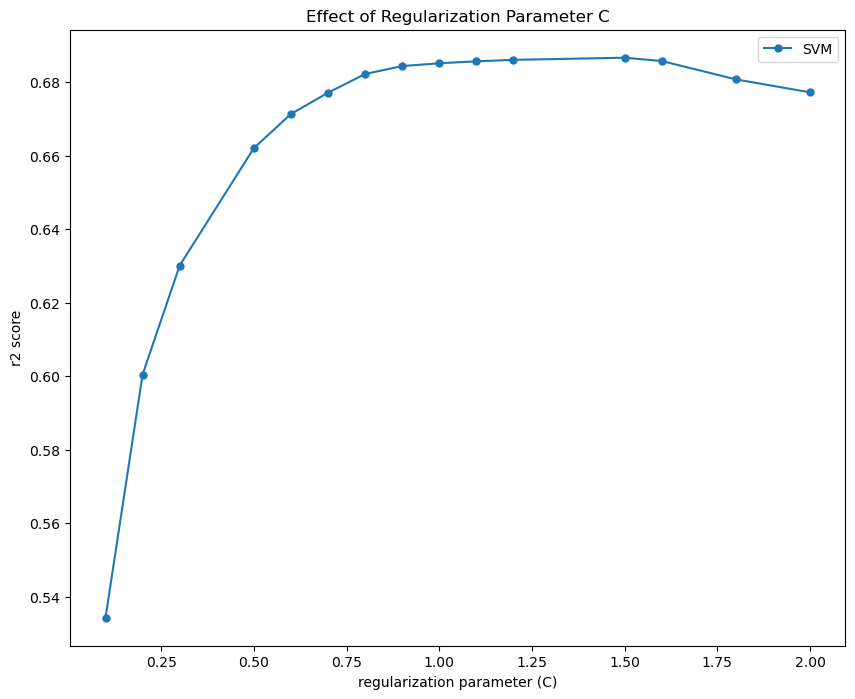

In [493]:
plt.figure(figsize=(10, 8))

x = [0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 1.6, 1.8, 2.0]
svr_r2_scores = [0.534311254659683, 0.60045849515602, 0.630105359951758, 0.662055443546966, 0.671337662196996, 0.677135855369468,
                0.682218856828731, 0.684383237679927, 0.685138768340891, 0.685673983889952, 0.686074553751873, 0.686652429626463, 
                0.685754849729717, 0.680762080482122, 0.677229565941978]

plt.title('Effect of Regularization Parameter C')
plt.xlabel('regularization parameter (C)')
plt.ylabel('r2 score')
plt.plot(x, svr_r2_scores, label='SVM', marker='o', markersize=5.0)

plt.legend()
plt.show()

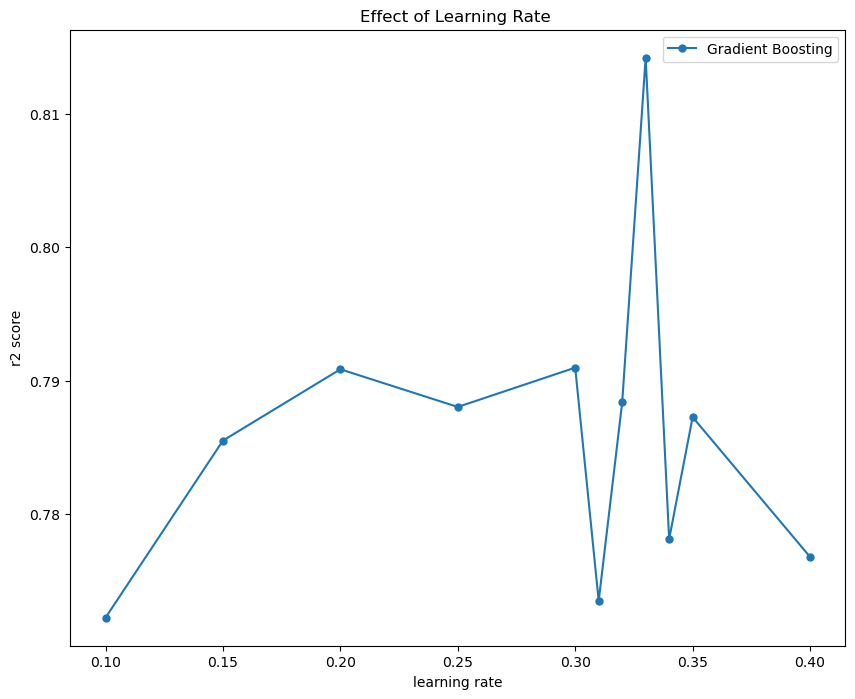

In [563]:
plt.figure(figsize=(10, 8))

x = [0.1, 0.15, 0.2, 0.25, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.4]
GB_r2_scores = [0.772241892017633, 0.785507270196266, 0.790850582708612, 0.788028266518991, 0.79097197450132, 0.773501984946502,
                0.788361964040499, 0.814184588136779, 0.778127420343183, 0.787266283703864, 0.776797371363193]

plt.title('Effect of Learning Rate ')
plt.xlabel('learning rate')
plt.ylabel('r2 score')
plt.plot(x, GB_r2_scores, label='Gradient Boosting', marker='o', markersize=5.0)

plt.legend()
plt.show()

In [508]:
regr2 = RandomForestRegressor(n_estimators=103, criterion='squared_error')
regr2.fit(X_train, y_train)
y_preds2 = regr2.predict(X_test)

evaluate_metrics(y_test, y_preds2)

r2 score is  0.7736786391320142
mean absolute error is  0.5613183122672039
explained variance score is  0.7743713347508399


In [558]:
regr3 = GradientBoostingRegressor(learning_rate=0.4, n_estimators= 110, criterion='friedman_mse')
regr3.fit(X_train, y_train)
y_preds3 = regr3.predict(X_test)

evaluate_metrics(y_test, y_preds3)

r2 score is  0.776797371363193
mean absolute error is  0.5823356949003805
explained variance score is  0.7801244250088258


In [481]:
regr4 = KNeighborsRegressor(n_neighbors=7)
regr4.fit(scaled_X_train, scaled_y_train)
y_preds4 = regr4.predict(scaled_X_test)

evaluate_metrics(scaled_y_test, y_preds4)

r2 score is  0.5911210173881427
mean absolute error is  0.4570317086636941
explained variance score is  0.5922915725894415


In [73]:
X = mod_df.drop('band_gap', axis=1)
y = mod_df['band_gap']

scaled_X = scale_features(X)
scaled_y = scale_features(np.array(y).reshape(len(y),1))

scaled_X

array([[-1.33762017,  1.22008061, -0.07105405, ..., -0.98244768,
        -0.98427483, -0.98311187],
       [-1.33762017,  0.3425319 , -0.84332686, ..., -2.12993268,
        -2.15290408, -1.95749491],
       [-1.33762017,  0.31278448, -0.59647906, ...,  0.3425871 ,
         0.36517603,  1.26718654],
       ...,
       [-1.04235953,  1.08621725, -0.95028829, ..., -0.98244803,
        -0.98427497, -0.98311183],
       [-0.74709889,  1.16058578,  0.11140693, ...,  0.3425871 ,
         0.36517603,  0.14203734],
       [-0.45183825,  0.64000604,  0.62954717, ...,  0.3425871 ,
         0.36517603,  1.26718639]])

In [88]:
model = svm.SVR(gamma='auto')
grid = GridSearchCV(model, {
    'C': [1, 1.5, 2],
    'kernel': ['linear', 'rbf']
}, cv=2, scoring='r2', return_train_score=False)

grid.fit(scaled_X, scaled_y)

gridSearch_res = pd.DataFrame(grid.cv_results_)
gridSearch_res = gridSearch_res[['param_C', 'param_kernel', 'mean_test_score']]

gridSearch_res

C:\Users\91910\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\91910\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\91910\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\91910\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

,param_C,param_kernel,mean_test_score
0,1,linear,-0.116899
1,1,rbf,0.441670
2,1.5,linear,-0.131312
3,1.5,rbf,0.435142
4,2,linear,-0.143038
5,2,rbf,0.418457
